# **GNN Final Project on ENZYMES Dataset**

## **0. Introduction**

**Goal:** Build, train, and evaluate a Graph Neural Network (GNN) on the ENZYMES dataset, experiment with hyperparameters, and visualize good/bad classifications.

- **Dataset:** 
  * [ENZYMES:Paperswithcode](https://paperswithcode.com/dataset/enzymes) 
  * [TUDataset](https://chrsmrrs.github.io/datasets/docs/datasets/)
- **Objective/task:** Multi-class graph classification (6 classes)
- **Approach:** 
  * Try out various message-passing GNN (GCN, SAGE, GAT, GIN) with simple architechture (Get optimal general algoritm)
  * Develop more complex architechture based on selected GNN + hyperparameter tuning (Get optimal model)
  * Visualize detailed performance of the optimal model

## **1. Setup & Imports**

Requirements:
* python==3.12.9
* CUDA==12.1.0
* torch==2.6.0
* torch-geometric==2.6.1
* networkx==3.4.2
* scikit-learn==1.6.1

In [106]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

import pandas as pd
import numpy as np
import random
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from utilities import train, evaluate

# Reproducibility
def set_seed(seed):
    """Set random seed for reproducibility across torch, numpy, and random."""
    import random
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Detect computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## **2. Load Dataset**

In [5]:
# load the ENZYMES dataset
dataset = TUDataset(root='./dataset', name='ENZYMES', use_node_attr=True)
print(dataset)
print('Number of graphs:', len(dataset))
print('Number of classes:', dataset.num_classes)
print('Number of node features:', dataset.num_node_features, end="\n\n")

# Inspect a sample graph
graph = dataset[0]
print(graph)
print('Node features shape:', graph.x.shape) # <-- 21 features each node (Homogeneous)
print('Edge index shape:', graph.edge_index.shape) # <-- no index attributes
print('Label:', graph.y.item())

Processing...


ENZYMES(600)
Number of graphs: 600
Number of classes: 6
Number of node features: 21

Data(edge_index=[2, 168], x=[37, 21], y=[1])
Node features shape: torch.Size([37, 21])
Edge index shape: torch.Size([2, 168])
Label: 5


Done!


In [92]:
data.x[0]

tensor([11.0000, 15.8870, 37.7800, -0.5100,  1.7010, 93.9000,  4.0000,  5.0000,
         2.0000,  4.0000,  4.0000,  3.0000,  3.0000,  4.0000,  4.0000,  3.0000,
         6.0000,  2.0000,  1.0000,  0.0000,  0.0000])

## **3. Train/Test Split**

Here we use stratified split to ensure each set has similar graph class distribution.

In [6]:
from torch.utils.data import Subset
from collections import defaultdict

def stratified_split(dataset, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=123):
    """
    Stratified split for graph datasets.
    Returns: train_indices, val_indices, test_indices
    """
    set_seed(seed)
    # Group indices by label
    label_to_indices = defaultdict(list)
    for idx, data in enumerate(dataset):
        label = int(data.y.item())
        label_to_indices[label].append(idx)
    
    train_idx, val_idx, test_idx = [], [], []
    for indices in label_to_indices.values():
        indices = np.array(indices)
        np.random.shuffle(indices)
        n = len(indices)
        n_train = int(train_ratio * n)
        n_val = int(val_ratio * n)
        n_test = int(test_ratio * n)
        # Get the train, val, and test indices
        train_idx.extend(indices[:n_train])
        val_idx.extend(indices[n_train:n_train + n_val])
        test_idx.extend(indices[n_train + n_val:])
    
    return train_idx, val_idx, test_idx

In [7]:
train_idx, val_idx, test_idx = stratified_split(dataset, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=123)

batch_size = 32
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## **4. Model Architecture Development**

### **4.1 Baseline Model**

Here we want to select the best option among the selected GNN algorithm (GCN, SAGE, GAT, GIN). The selection is based on the average accuracy of 5 training runs of each model. All models contain 3 layers GNN + 3 layers MLP head.

In [97]:
from torch_geometric.nn import MLP, GCN, GraphSAGE, GIN, GAT

# Base GNN Net for multiclass classification
class Base_GNN_Net(nn.Module):
    """
    Base GNN Net for multiclass classification using 3-layer GNN of selected type and a 3-layer MLP classification head.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, gnn_type="GCN", dropout=0.3, mlp_hidden_dim=64):
        super(Base_GNN_Net, self).__init__()
        # Create GNN convolutional layers
        if gnn_type == "GCN":
            self.gnn = GCN(
                in_channels=in_channels, 
                hidden_channels=hidden_channels, 
                num_layers=3, 
                out_channels=hidden_channels,
                dropout=dropout
            )
        elif gnn_type == "GraphSAGE":
            self.gnn = GraphSAGE(
                in_channels=in_channels, 
                hidden_channels=hidden_channels, 
                num_layers=3, 
                out_channels=hidden_channels,
                dropout=dropout
            )
        elif gnn_type == "GIN":
            self.gnn = GIN(
                in_channels=in_channels, 
                hidden_channels=hidden_channels, 
                num_layers=3, 
                out_channels=hidden_channels,
                dropout=dropout
            )
        elif gnn_type == "GAT":
            self.gnn = GAT(
                in_channels=in_channels,
                hidden_channels=hidden_channels,
                out_channels=hidden_channels,
                num_layers=3,
                heads=4,
                v2=True,
                dropout=dropout
            )
        else:
            raise ValueError(f"Unknown model_type '{gnn_type}'. Use 'GCN', 'GraphSAGE', 'GIN', or 'GAT'.")
        
        # Create MLP classification head
        self.mlp_head = MLP(
            in_channels=hidden_channels,
            hidden_channels=mlp_hidden_dim,
            out_channels=out_channels,
            num_layers=3,
            dropout=dropout,
            act='relu',
            norm=None
        )

    def forward(self, x, edge_index, batch):
        x = self.gnn(x, edge_index)
        x = global_mean_pool(x, batch)
        logits = self.mlp_head(x)
        return logits

In [100]:
# Benchmark all base model for 5 runs
gnn_classes = ['GCN', 'GraphSAGE', 'GIN', 'GAT']
seeds = [1, 10, 100, 1000, 10000]
epochs = 50; lr = 0.001
acc_results = {cls: [] for cls in gnn_classes}
mem_results = {cls: [] for cls in gnn_classes}

for gnn_class in gnn_classes:
    for seed in seeds:
        set_seed(seed)
        
        model = Base_GNN_Net(
            in_channels=dataset.num_node_features,
            hidden_channels=128,
            out_channels=dataset.num_classes,
            gnn_type=gnn_class,
            dropout=0.0
        ).to(device)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        torch.cuda.reset_peak_memory_stats()
        best_val = 0
        
        for epoch in range(epochs):
            loss = train(model, train_loader, optimizer, criterion)
            val_acc, _, _ = evaluate(model, val_loader)
            if val_acc > best_val:
                best_val = val_acc
                best_model_state = model.state_dict()
                
        model.load_state_dict(best_model_state)
        test_acc, y_true, y_pred = evaluate(model, test_loader)
        max_mem = torch.cuda.max_memory_allocated() / (1024 ** 2) # Max. GPU memory utilization (in MB)
        
        acc_results[gnn_class].append(test_acc)
        mem_results[gnn_class].append(max_mem)
        print(f"{gnn_class} | Seed={seed}: ValAcc={best_val:.3f}, TestAcc={test_acc:.3f}")

# Summary statistics:
for model_name, accs in acc_results.items():
    print(f"{model_name}: mean={np.mean(accs):.3f}, std={np.std(accs):.3f}, all={accs}")

GCN | Seed=1: ValAcc=0.350, TestAcc=0.450
GCN | Seed=10: ValAcc=0.400, TestAcc=0.467
GCN | Seed=100: ValAcc=0.400, TestAcc=0.433
GCN | Seed=1000: ValAcc=0.417, TestAcc=0.467
GCN | Seed=10000: ValAcc=0.383, TestAcc=0.450
GraphSAGE | Seed=1: ValAcc=0.400, TestAcc=0.517
GraphSAGE | Seed=10: ValAcc=0.467, TestAcc=0.517
GraphSAGE | Seed=100: ValAcc=0.450, TestAcc=0.433
GraphSAGE | Seed=1000: ValAcc=0.400, TestAcc=0.483
GraphSAGE | Seed=10000: ValAcc=0.383, TestAcc=0.483
GIN | Seed=1: ValAcc=0.367, TestAcc=0.300
GIN | Seed=10: ValAcc=0.433, TestAcc=0.383
GIN | Seed=100: ValAcc=0.367, TestAcc=0.417
GIN | Seed=1000: ValAcc=0.367, TestAcc=0.383
GIN | Seed=10000: ValAcc=0.367, TestAcc=0.450
GAT | Seed=1: ValAcc=0.500, TestAcc=0.600
GAT | Seed=10: ValAcc=0.467, TestAcc=0.617
GAT | Seed=100: ValAcc=0.433, TestAcc=0.583
GAT | Seed=1000: ValAcc=0.417, TestAcc=0.533
GAT | Seed=10000: ValAcc=0.500, TestAcc=0.533
GCN: mean=0.453, std=0.012, all=[0.45, 0.4666666666666667, 0.43333333333333335, 0.46666666

In [ ]:
# import pandas as pd

# acc_df = pd.DataFrame(acc_results)
# acc_df.to_excel("base_model_benchmark_results_acc.xlsx", index=False, sheet_name="test_acc", engine='xlsxwriter')
# mem_df = pd.DataFrame(mem_results)
# mem_df.to_excel("base_model_benchmark_results_mem.xlsx", index=False, sheet_name="max_memory", engine='xlsxwriter')

### **4.2 Model Optimization**

Based on 4.1, the two GNN types that are most optimal for this dataset are GraphSAGE and GAT. Therefore, I selected them for hyperparameter tuning to get the optimal model architechture. 

Before hyperparameter tuning, I will explore improvement that can be done by tweaking the model behavior (jumping knowledge, normalization)

In [85]:
import torch_geometric.nn as tg_nn
from torch_geometric.nn import MLP, GraphSAGE

class GraphSAGE_Net(nn.Module):
    """
    Boilerplate GraphSAGE NN to test different model behavior
    """
    def __init__(self, in_channels, hidden_channels, out_channels,
        num_layers=2, norm_cls=None, jk=None, dropout=0.3,
        mlp_layers=3, mlp_hidden_dim=128
    ):
        super().__init__()
        self.sage_layers = GraphSAGE(in_channels=in_channels, 
                                     hidden_channels=hidden_channels, 
                                     num_layers=num_layers, 
                                     out_channels=hidden_channels, 
                                     dropout=dropout,
                                     norm=norm_cls,
                                     jk=jk)
        
        self.mlp_head = MLP(in_channels=hidden_channels, 
                            hidden_channels=mlp_hidden_dim, 
                            out_channels=out_channels, 
                            dropout=dropout,
                            num_layers=mlp_layers)

    def forward(self, x, edge_index, batch):
        x = self.sage_layers(x, edge_index)
        x = global_mean_pool(x, batch)
        logits = self.mlp_head(x)
        return logits

In [ ]:
epochs = 100; gnn_hidden_dim = 128
dropouts = [0.0, 0.2, 0.3, 0.5]
seeds = [1, 10, 100, 1000, 10000]
normalizations = {"None":None,
                  "Batch":tg_nn.BatchNorm(gnn_hidden_dim),
                  "Layer":tg_nn.LayerNorm(gnn_hidden_dim),
                  "Graph":tg_nn.GraphNorm(gnn_hidden_dim)}
jumping_knowledges = [None,
                      "cat",
                      "max"]



In [102]:
# Test the effect of dropout fractions
results_dropout = []
for dropout in dropouts:
    for seed in seeds:
        set_seed(seed)
        model = GraphSAGE_Net(in_channels=dataset.num_node_features, 
                      hidden_channels=gnn_hidden_dim, 
                      out_channels=dataset.num_classes, 
                      num_layers=3, dropout=dropout).to(device)
        best_val = 0
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()
        
        for epoch in range(epochs):
            loss = train(model, train_loader, optimizer, criterion)
            val_acc, _, _ = evaluate(model, val_loader)
            if val_acc > best_val:
                best_val = val_acc
                best_model_state = model.state_dict()
        model.load_state_dict(best_model_state)
        test_acc, y_true, y_pred = evaluate(model, test_loader)
        print(f"seed={seed}, dropout={dropout}: ValAcc={best_val:.3f}, TestAcc={test_acc:.3f}")
        results_dropout.append({
            'seed': seed,
            'dropout': dropout,
            'val_acc': best_val,
            'test_acc': test_acc,
        })

seed=1, dropout=0.0: ValAcc=0.550, TestAcc=0.450
seed=10, dropout=0.0: ValAcc=0.550, TestAcc=0.500
seed=100, dropout=0.0: ValAcc=0.567, TestAcc=0.617
seed=1000, dropout=0.0: ValAcc=0.567, TestAcc=0.617
seed=10000, dropout=0.0: ValAcc=0.600, TestAcc=0.517
seed=1, dropout=0.2: ValAcc=0.500, TestAcc=0.517
seed=10, dropout=0.2: ValAcc=0.517, TestAcc=0.617
seed=100, dropout=0.2: ValAcc=0.550, TestAcc=0.617
seed=1000, dropout=0.2: ValAcc=0.550, TestAcc=0.683
seed=10000, dropout=0.2: ValAcc=0.567, TestAcc=0.550
seed=1, dropout=0.3: ValAcc=0.483, TestAcc=0.500
seed=10, dropout=0.3: ValAcc=0.500, TestAcc=0.583
seed=100, dropout=0.3: ValAcc=0.483, TestAcc=0.550
seed=1000, dropout=0.3: ValAcc=0.533, TestAcc=0.500
seed=10000, dropout=0.3: ValAcc=0.500, TestAcc=0.600
seed=1, dropout=0.5: ValAcc=0.350, TestAcc=0.383
seed=10, dropout=0.5: ValAcc=0.350, TestAcc=0.433
seed=100, dropout=0.5: ValAcc=0.417, TestAcc=0.500
seed=1000, dropout=0.5: ValAcc=0.383, TestAcc=0.483
seed=10000, dropout=0.5: ValAcc=0

In [ ]:
# dropout_df = pd.DataFrame(results_dropout)
# dropout_df.to_excel("SAGE_dropout_ft.xlsx", index=False, sheet_name="dropout", engine='xlsxwriter')

In [105]:
# Test the effect of normalization methods
results_norm = []
for norm, norm_cls in normalizations.items():
    for seed in seeds:
        set_seed(seed)
        model = GraphSAGE_Net(in_channels=dataset.num_node_features, 
                      hidden_channels=gnn_hidden_dim, 
                      out_channels=dataset.num_classes, 
                      num_layers=3, dropout=0.2, norm_cls=norm_cls).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()
        best_val = 0
        
        for epoch in range(epochs):
            loss = train(model, train_loader, optimizer, criterion)
            val_acc, _, _ = evaluate(model, val_loader)
            if val_acc > best_val:
                best_val = val_acc
                best_model_state = model.state_dict()
        model.load_state_dict(best_model_state)
        test_acc, y_true, y_pred = evaluate(model, test_loader)
        print(f"seed={seed}, norm={norm}: ValAcc={best_val:.3f}, TestAcc={test_acc:.3f}")
        results_norm.append({
            'seed': seed,
            'norm_method': norm,
            'val_acc': best_val,
            'test_acc': test_acc,
        })

seed=1, norm=None: ValAcc=0.583, TestAcc=0.517
seed=10, norm=None: ValAcc=0.550, TestAcc=0.533
seed=100, norm=None: ValAcc=0.567, TestAcc=0.600
seed=1000, norm=None: ValAcc=0.533, TestAcc=0.617
seed=10000, norm=None: ValAcc=0.567, TestAcc=0.600
seed=1, norm=Batch: ValAcc=0.650, TestAcc=0.600
seed=10, norm=Batch: ValAcc=0.617, TestAcc=0.583
seed=100, norm=Batch: ValAcc=0.617, TestAcc=0.617
seed=1000, norm=Batch: ValAcc=0.667, TestAcc=0.700
seed=10000, norm=Batch: ValAcc=0.617, TestAcc=0.683
seed=1, norm=Layer: ValAcc=0.550, TestAcc=0.550
seed=10, norm=Layer: ValAcc=0.467, TestAcc=0.400
seed=100, norm=Layer: ValAcc=0.500, TestAcc=0.567
seed=1000, norm=Layer: ValAcc=0.583, TestAcc=0.500
seed=10000, norm=Layer: ValAcc=0.517, TestAcc=0.600
seed=1, norm=Graph: ValAcc=0.600, TestAcc=0.583
seed=10, norm=Graph: ValAcc=0.567, TestAcc=0.533
seed=100, norm=Graph: ValAcc=0.600, TestAcc=0.583
seed=1000, norm=Graph: ValAcc=0.600, TestAcc=0.583
seed=10000, norm=Graph: ValAcc=0.617, TestAcc=0.583


In [108]:
norm_df = pd.DataFrame(results_norm)
norm_df.to_excel("SAGE_norm_ft.xlsx", index=False, sheet_name="norm", engine='xlsxwriter')

In [109]:
# Test the effect of jumping knowledges method
results_jk = []
for jk in jumping_knowledges:
    for seed in seeds:
        set_seed(seed)
        model = GraphSAGE_Net(in_channels=dataset.num_node_features, 
                      hidden_channels=gnn_hidden_dim, 
                      out_channels=dataset.num_classes, 
                      num_layers=3, dropout=0.2, norm_cls=tg_nn.BatchNorm(gnn_hidden_dim)).to(device)
        best_val = 0
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()
        
        for epoch in range(epochs):
            loss = train(model, train_loader, optimizer, criterion)
            val_acc, _, _ = evaluate(model, val_loader)
            if val_acc > best_val:
                best_val = val_acc
                best_model_state = model.state_dict()
        model.load_state_dict(best_model_state)
        test_acc, y_true, y_pred = evaluate(model, test_loader)
        print(f"seed={seed}, jk={jk}: ValAcc={best_val:.3f}, TestAcc={test_acc:.3f}")
        results_jk.append({
            'seed': seed,
            'jk': jk,
            'val_acc': best_val,
            'test_acc': test_acc,
        })

seed=1, jk=None: ValAcc=0.633, TestAcc=0.733
seed=10, jk=None: ValAcc=0.633, TestAcc=0.583
seed=100, jk=None: ValAcc=0.600, TestAcc=0.667
seed=1000, jk=None: ValAcc=0.667, TestAcc=0.617
seed=10000, jk=None: ValAcc=0.617, TestAcc=0.550
seed=1, jk=cat: ValAcc=0.617, TestAcc=0.683
seed=10, jk=cat: ValAcc=0.583, TestAcc=0.600
seed=100, jk=cat: ValAcc=0.633, TestAcc=0.583
seed=1000, jk=cat: ValAcc=0.683, TestAcc=0.583
seed=10000, jk=cat: ValAcc=0.617, TestAcc=0.600
seed=1, jk=max: ValAcc=0.617, TestAcc=0.700
seed=10, jk=max: ValAcc=0.667, TestAcc=0.600
seed=100, jk=max: ValAcc=0.633, TestAcc=0.650
seed=1000, jk=max: ValAcc=0.633, TestAcc=0.650
seed=10000, jk=max: ValAcc=0.617, TestAcc=0.650


In [ ]:
# jk_df = pd.DataFrame(results_jk)
# jk_df.to_excel("SAGE_jk_ft.xlsx", index=False, sheet_name="jk", engine='xlsxwriter')

From the sequential model parameter optimization experiment, the best test accuracy was obtained with the following configurations:
* dropout = 0.2
* normalization method = batch
* jumping knowledge method = max

## **5. Performance-Memory Tradeoff Experiment**

To see whether increasing the number of parameters is worth doing, we will do a performance test after the addition of more trainable parameters via increasing the GNN layer hidden dimensions and/or increasing the layer amount.

In [121]:
results = []
gnn_hidden_dims = [64, 128, 256]
gnn_num_layers = [3, 4, 5, 6]
seeds = [10, 100, 1000]
epochs = 100

for hidden_dim in gnn_hidden_dims:
    for num_layer in gnn_num_layers:
        for seed in seeds:
            set_seed(seed)
            model = GraphSAGE_Net(in_channels=dataset.num_node_features, hidden_channels=hidden_dim, 
                        out_channels=dataset.num_classes, num_layers=num_layer, 
                        dropout=0.2, norm_cls=tg_nn.BatchNorm(hidden_dim), jk="max").to(device)
            
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            criterion = nn.CrossEntropyLoss()
            best_val = 0
            torch.cuda.reset_peak_memory_stats()
            
            for epoch in range(epochs):
                loss = train(model, train_loader, optimizer, criterion)
                val_acc, _, _ = evaluate(model, val_loader)
                if val_acc > best_val:
                    best_val = val_acc
                    best_model_state = model.state_dict()
            model.load_state_dict(best_model_state)
            test_acc, y_true, y_pred = evaluate(model, test_loader)
            max_mem = torch.cuda.max_memory_allocated() / (1024 ** 2) # Max. GPU memory utilization (in MB)
            
            print(f"gnn_h_dim={hidden_dim}, gnn_n_layer={num_layer}: ValAcc={best_val:.3f}, TestAcc={test_acc:.3f}")
            results.append({
                'seed': seed,
                'gnn_h_dim': hidden_dim,
                'gnn_n_layer': num_layer,
                'gnn_layout': '('+str(hidden_dim)+', '+str(num_layer)+')',
                'max_memory': max_mem,
                'val_acc': best_val,
                'test_acc': test_acc,
                # 'y_true': y_true,
                # 'y_pred': y_pred
            })

gnn_h_dim=64, gnn_n_layer=3: ValAcc=0.667, TestAcc=0.700
gnn_h_dim=64, gnn_n_layer=3: ValAcc=0.700, TestAcc=0.733
gnn_h_dim=64, gnn_n_layer=3: ValAcc=0.667, TestAcc=0.750
gnn_h_dim=64, gnn_n_layer=4: ValAcc=0.633, TestAcc=0.550
gnn_h_dim=64, gnn_n_layer=4: ValAcc=0.667, TestAcc=0.617
gnn_h_dim=64, gnn_n_layer=4: ValAcc=0.683, TestAcc=0.700
gnn_h_dim=64, gnn_n_layer=5: ValAcc=0.650, TestAcc=0.600
gnn_h_dim=64, gnn_n_layer=5: ValAcc=0.700, TestAcc=0.617
gnn_h_dim=64, gnn_n_layer=5: ValAcc=0.633, TestAcc=0.667
gnn_h_dim=64, gnn_n_layer=6: ValAcc=0.600, TestAcc=0.650
gnn_h_dim=64, gnn_n_layer=6: ValAcc=0.733, TestAcc=0.650
gnn_h_dim=64, gnn_n_layer=6: ValAcc=0.650, TestAcc=0.683
gnn_h_dim=128, gnn_n_layer=3: ValAcc=0.683, TestAcc=0.750
gnn_h_dim=128, gnn_n_layer=3: ValAcc=0.683, TestAcc=0.733
gnn_h_dim=128, gnn_n_layer=3: ValAcc=0.700, TestAcc=0.667
gnn_h_dim=128, gnn_n_layer=4: ValAcc=0.683, TestAcc=0.667
gnn_h_dim=128, gnn_n_layer=4: ValAcc=0.700, TestAcc=0.717
gnn_h_dim=128, gnn_n_layer

In [123]:
performance_df = pd.DataFrame(results)
performance_df.to_excel("performance_memory_tradeoff.xlsx", index=False, sheet_name="tradeoff", engine='xlsxwriter')

## **6. Best Model Evaluation**

To see whether increasing the number of parameters is worth doing, we will do a performance test after the addition of more trainable parameters via increasing the GNN layer hidden dimensions and/or increasing the layer amount.

In [126]:
results_best = []
best_model = GraphSAGE_Net(in_channels=dataset.num_node_features, hidden_channels=64, 
            out_channels=dataset.num_classes, num_layers=3, 
            dropout=0.2, norm_cls=tg_nn.BatchNorm(64), jk="max").to(device)

optimizer = torch.optim.Adam(best_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
best_val = 0
# torch.cuda.reset_peak_memory_stats()

for epoch in range(200):
    loss = train(best_model, train_loader, optimizer, criterion)
    val_acc, _, _ = evaluate(best_model, val_loader)
    if val_acc > best_val:
        best_val = val_acc
        best_model_state = best_model.state_dict()
best_model.load_state_dict(best_model_state)
test_acc, y_true, y_pred = evaluate(best_model, test_loader)
# max_mem = torch.cuda.max_memory_allocated() / (1024 ** 2) # Max. GPU memory utilization (in MB)

print(f"gnn_h_dim=64, gnn_n_layer=3: ValAcc={best_val:.3f}, TestAcc={test_acc:.3f}")
results_best.append({
    'seed': seed,
    'val_acc': best_val,
    'test_acc': test_acc,
    'y_true': y_true,
    'y_pred': y_pred
})

gnn_h_dim=64, gnn_n_layer=3: ValAcc=0.750, TestAcc=0.783


              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       1.00      0.70      0.82        10
           2       0.67      1.00      0.80        10
           3       1.00      0.50      0.67        10
           4       0.75      0.90      0.82        10
           5       0.71      1.00      0.83        10

    accuracy                           0.78        60
   macro avg       0.83      0.78      0.77        60
weighted avg       0.83      0.78      0.77        60



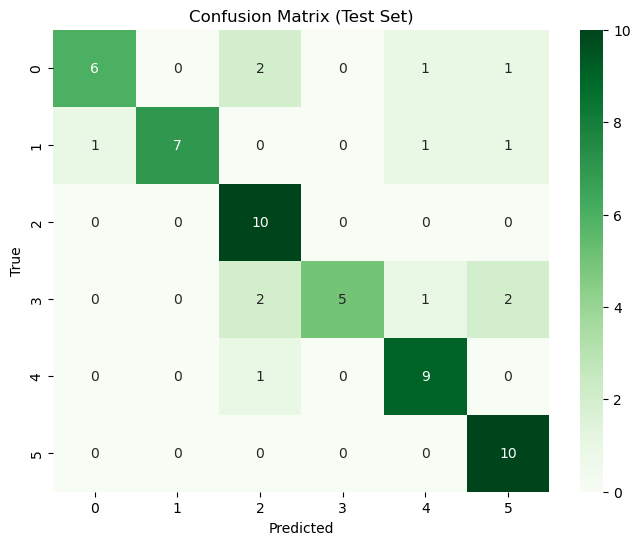

In [181]:
labels = ["EC 1", "EC 2", "EC 3", "EC 4", "EC 5", "EC 6"]
all_loader = DataLoader(dataset, batch_size=32, shuffle=True)

test_acc, y_true, y_pred = evaluate(best_model, test_loader)
clas_report_dict = classification_report(y_true, y_pred, output_dict=True)
clas_report = classification_report(y_true, y_pred)
report_df = pd.DataFrame(clas_report_dict)
print(clas_report)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [179]:
report_df.to_excel("classification-report.xlsx", index=False, sheet_name="clas-report", engine='xlsxwriter')

## 7. **Visualizing Good and Bad Predictions**

torch.Size([41, 21])
41


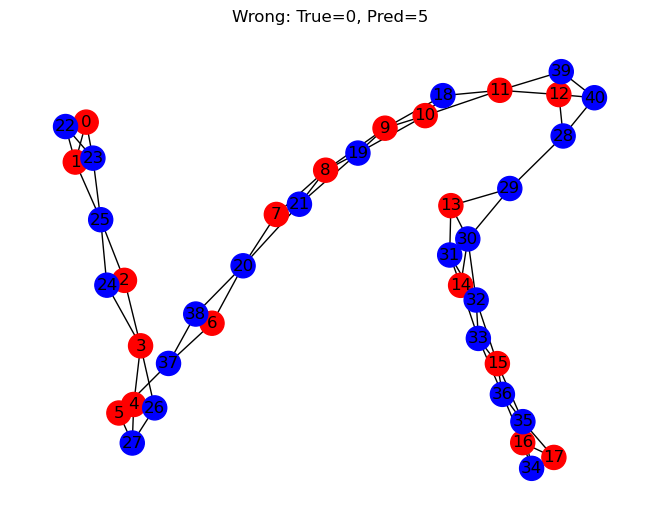

torch.Size([24, 21])
24


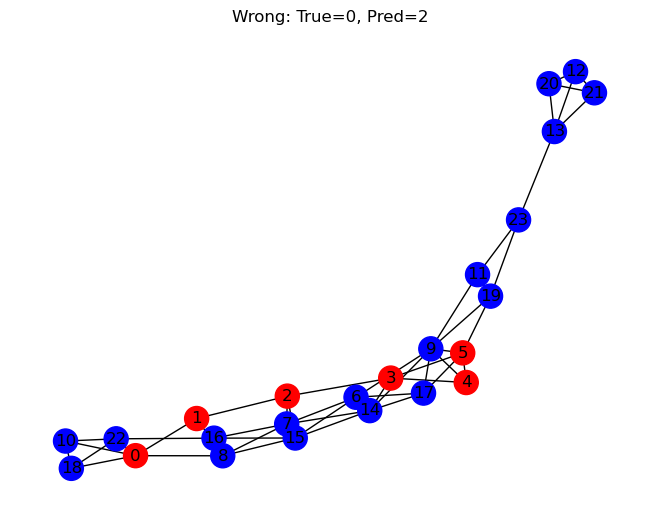

torch.Size([42, 21])
42


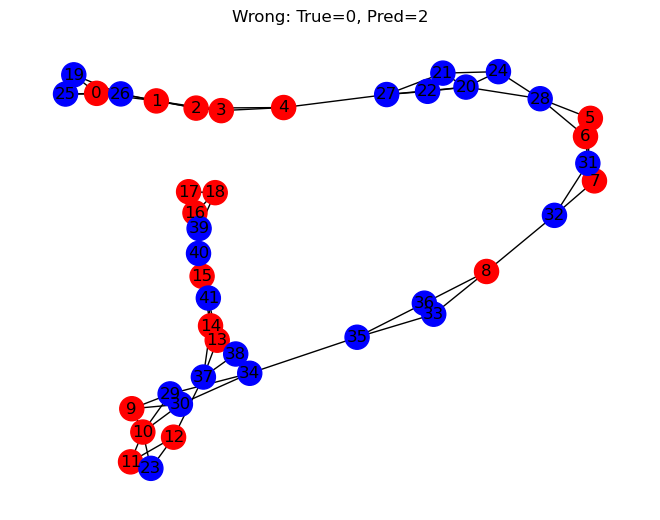

torch.Size([44, 21])
44


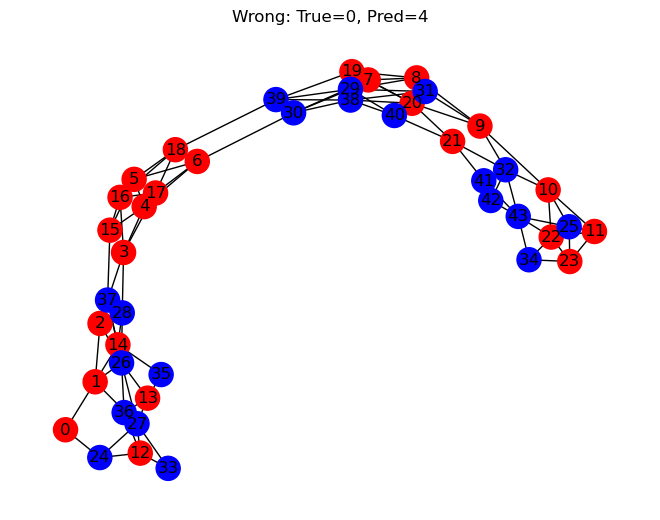

torch.Size([84, 21])
84


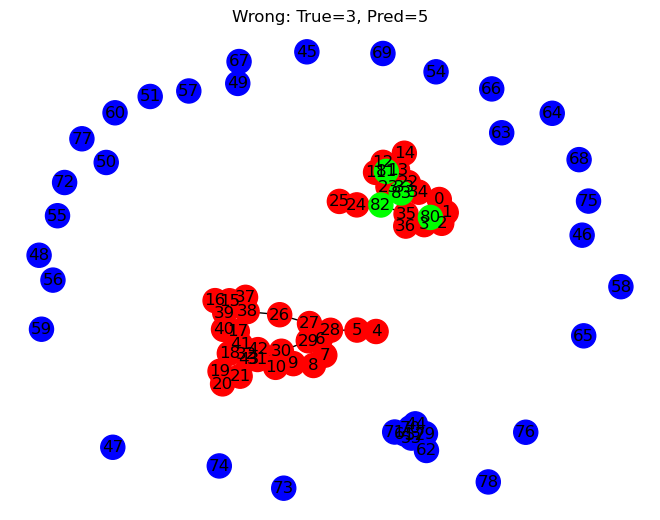

torch.Size([44, 21])
44


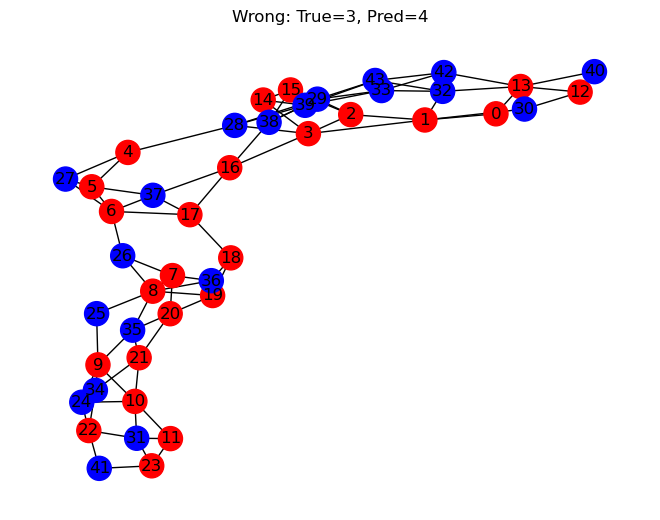

torch.Size([51, 21])
51


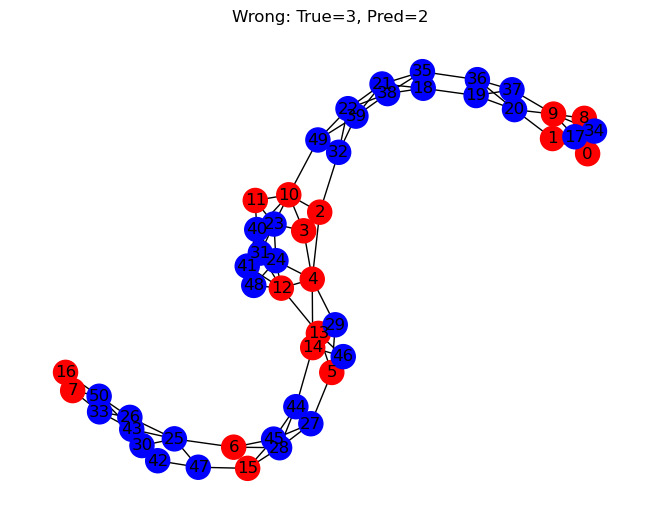

torch.Size([48, 21])
48


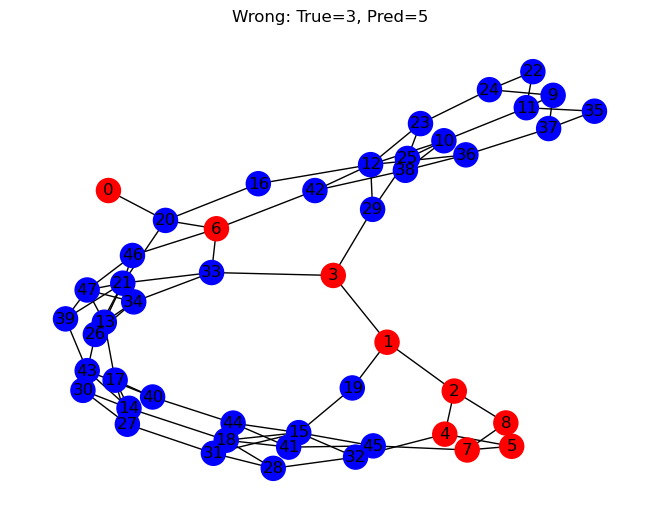

torch.Size([35, 21])
35


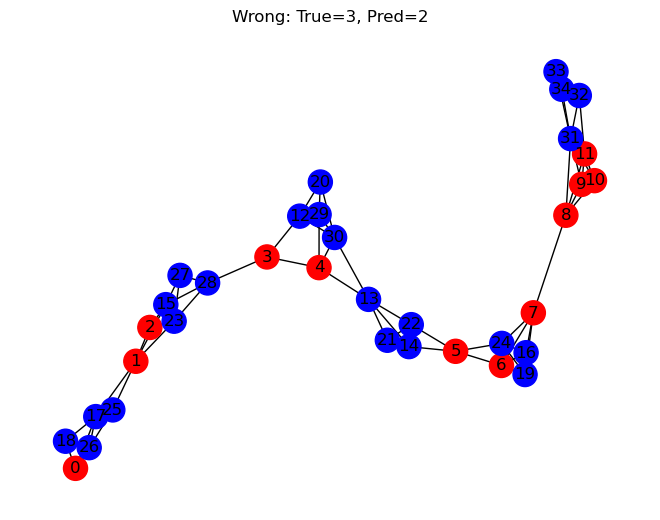

In [ ]:
import networkx as nx
# Load best model
best_model.eval()

test_graphs = list(test_dataset)
preds = []
for data in test_graphs:
    data = data.to(device)
    out = best_model(data.x, data.edge_index, torch.zeros_like(data.y))
    pred = out.argmax(dim=1).item()
    preds.append(pred)

# Visualize a few correctly classified and incorrectly classified graphs
correct = [i for i, (y, p) in enumerate(zip(y_true, y_pred)) if y==p]
incorrect = [i for i, (y, p) in enumerate(zip(y_true, y_pred)) if y!=p]
# print(correct)
# print(test_graphs[31].y==1)

def plot_graph(data, title):

    edge_index = data.edge_index.cpu().numpy()
    y_colours = ["#FF0000","#0000FF", "#00FF00"]
    G = nx.Graph()
    # Add all nodes explicitly
    num_nodes = data.x.shape[0]
    G.add_nodes_from(range(num_nodes))

    # Add edges
    G.add_edges_from(edge_index.T)
    
    node_colors = []
    print(data.x.shape)
    for node in data.x:
        if node[18]:
            node_colors.append(y_colours[0])
        elif node[19]:
            node_colors.append(y_colours[1])
        else:
            node_colors.append(y_colours[2])
    print(len(node_colors))
    nx.draw(G, node_color=node_colors, with_labels=True)
    plt.title(title)
    plt.show()

# Bad predictions
for idx in incorrect[:]:
    if test_graphs[idx].y==3 or test_graphs[idx].y==0:
        # print(test_graphs[idx].x[:, 20])
        plot_graph(test_graphs[idx], f'Wrong: True={y_true[idx]}, Pred={y_pred[idx]}')

torch.Size([30, 21])
30


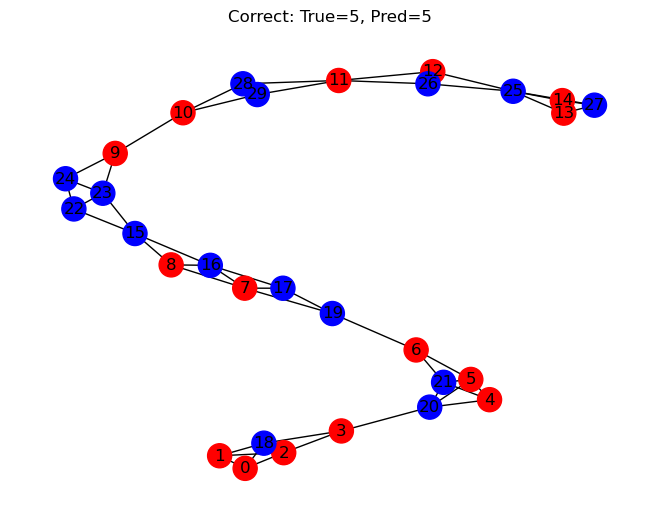

torch.Size([39, 21])
39


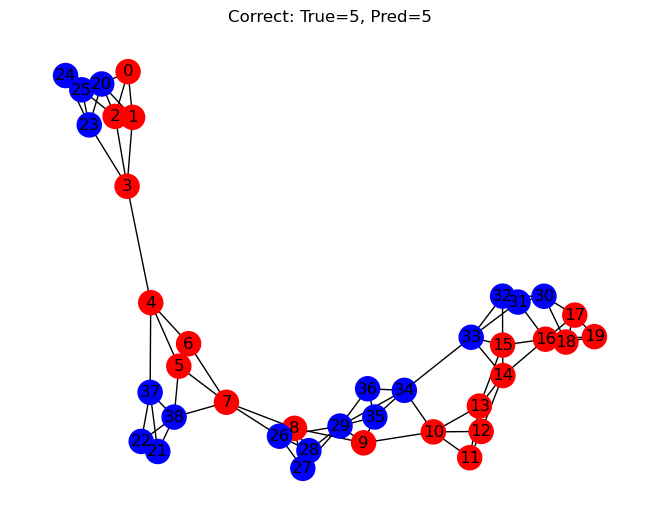

torch.Size([42, 21])
42


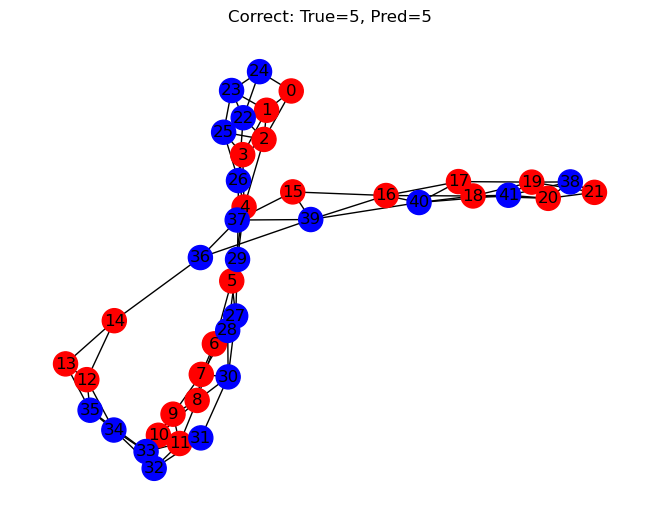

torch.Size([32, 21])
32


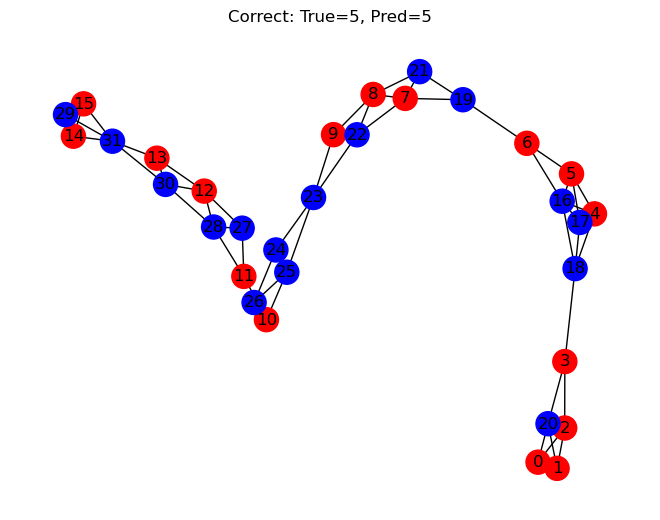

torch.Size([40, 21])
40


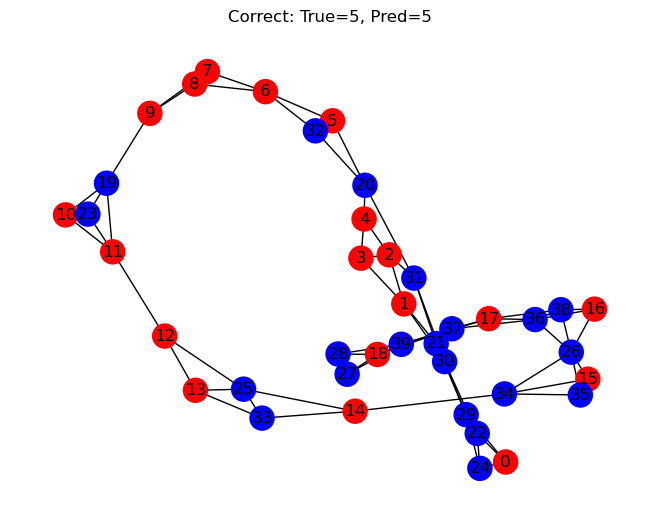

In [ ]:
# Good predictions
for idx in correct[:5]:
    plot_graph(test_graphs[idx], f'Correct: True={y_true[idx]}, Pred={y_pred[idx]}')

# 10. Conclusion

- GCN (2-layer, hidden=32) achieves around XX% test accuracy on ENZYMES with modest resources.
- Hyperparameter tuning shows ...
- Visualization of correct/wrong classifications provides insights into the model's strengths and weaknesses.

> **You can further reduce the number of graphs or number of epochs for faster experiments.**

## References
- Kipf, T. N., & Welling, M. (2016). Semi-Supervised Classification with Graph Convolutional Networks. arXiv:1609.02907.
- Dwivedi et al. (2020). Benchmarking Graph Neural Networks. arXiv:2003.00982.